In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# build the dataset
block_size = 3 #context size
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * 3
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(f'{"".join(itos[i] for i in context)} ----> {itos[ix]}')
        context = context[1:] + [ix] #update context

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [5]:
# Implementing Embedding matrix C (embedding lookup table: transforms characters/words into a vector)

C = torch.randn((27,2)) # in this example each context block is transformed into a 2D vector

emb = C[X] #embedding X

emb.shape #number of blocks, block size, nº of params/dimensions of the vector

torch.Size([32, 3, 2])

In [6]:
torch.cat(torch.unbind(emb, 1), 1).shape
#unbind separates gives list of tensors equivalent to [emb[:,0,:], emb[:,1,:], emb[:,2,:]]; we get all the parts of the context separatelly
#cat concatenates the three vectors and reduces the tensor dimension into 32*6 (instead of 32*3*2)
#this allows to perform matrix multiplication between emb and W1(the params of hidden layer that also have dim 32*6)
#inneficient

torch.Size([32, 6])

In [7]:
# equivalent to last cell
emb.view(-1,6).shape #transforms tensor shape into a 32*6 similarly to last cell but more efficiently and easier. -1 is equivalent to emb.shape[0] in this case

torch.Size([32, 6])

In [8]:
# Hidden Layer

W1 = torch.randn((6,100)) # initializing params: nº of inputs to the layer (context length * vector dim (3*2 = 6), nº of neurons in the hidden layer hyperparameter (100))
b1 = torch.randn(100) # biases for hidden layer

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # gives activations of hidden layer
h.shape
 

torch.Size([32, 100])

In [9]:
#Out Layer

W2 = torch.randn((100,27))
b2 = torch.randn(27) #number of character

logits = h @ W2 +b2

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [10]:
prob.shape

torch.Size([32, 27])

In [11]:
loss = - prob[torch.arange(32), Y].log().mean() #neg log likelihood loss
loss


tensor(19.3759)

Re-organizing the code

In [12]:
# Dataset
# build the dataset
block_size = 3 #context size
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] #update context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [25]:
#Initializing parameters

g = torch.Generator().manual_seed(2147483647) #seed
C = torch.randn((27,2), generator = g) # embedding matrix

#hidden layer
W1 = torch.randn((6,100), generator = g) 
b1 = torch.randn(100, generator = g)

#out layer
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

#Parameters
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters) #tot number of params

3481

In [27]:
for p in parameters:
    p.requires_grad = True

Training the NN

In [20]:
#Training the NN. Using mini-batch grad descent.

for i in range(10000):

    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[X[ix]] #embedding minibatch

    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #activations of hidden layer

    logits = h @ W2 + b2
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim = True) #getting out probabilities
    #loss = - prob[torch.arange(32), Y].log().mean() #neg log likelihood loss 
    loss = F.cross_entropy(logits, Y[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).
    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0

    loss.backward()

    #update parameters
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad 

#print(loss.item())

2.4960827827453613
2.2260825634002686
2.545236825942993
2.431306838989258
2.298275947570801
2.35649037361145
2.4084057807922363
2.3988027572631836
2.3214380741119385
2.6446645259857178
2.06506085395813
2.6944315433502197
2.5716066360473633
2.18066668510437
2.5511043071746826
2.570510149002075
2.4116899967193604
2.1825485229492188
2.2448885440826416
2.7512660026550293
2.6357645988464355
2.5009915828704834
2.5570356845855713
2.7637929916381836
2.2908122539520264
2.7356436252593994
2.4979918003082275
2.3124072551727295
2.1550002098083496
2.6599345207214355
2.2999751567840576
2.3037683963775635
2.4612176418304443
2.23465633392334
2.154069423675537
2.721374034881592
2.875293254852295
2.5790886878967285
2.6587748527526855
2.627349376678467
2.3803884983062744
2.595297336578369
2.674687147140503
2.53525447845459
2.4480185508728027
2.9341824054718018
2.371394634246826
2.101660966873169
2.475534200668335
2.8162457942962646
2.4695005416870117
2.849822998046875
2.212822198867798
2.5130670070648193

In [21]:
#Now check loss for full dataset (not minibatch)
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3998, grad_fn=<NllLossBackward0>)

Tuning learning rate

In [22]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 10**lre #setting lr to different values (between 0.001 and 1) to be able to optimize

In [28]:
#Training the NN. Using mini-batch grad descent. Tuning learning rate.

lri = []
lossi = []

for i in range(1000):

    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[X[ix]] #embedding minibatch

    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #activations of hidden layer

    logits = h @ W2 + b2
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim = True) #getting out probabilities
    #loss = - prob[torch.arange(32), Y].log().mean() #neg log likelihood loss 
    loss = F.cross_entropy(logits, Y[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).
    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0

    loss.backward()

    #update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad 

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())

#print(loss.item())

19.156089782714844
18.672657012939453
18.36400032043457
20.933990478515625
19.125930786132812
21.086727142333984
18.569660186767578
16.40169906616211
20.058868408203125
20.95823860168457
17.993419647216797
21.2445011138916
19.963449478149414
21.087486267089844
18.927330017089844
21.349018096923828
18.010814666748047
16.92028045654297
17.0368595123291
16.535051345825195
18.889097213745117
18.726774215698242
20.293731689453125
20.890884399414062
17.7282657623291
17.192174911499023
18.586612701416016
18.982458114624023
19.059341430664062
17.87379264831543
16.53309440612793
21.225982666015625
16.29867172241211
19.21240234375
18.312410354614258
17.63140296936035
16.134946823120117
17.5821533203125
18.54244041442871
18.12596893310547
16.318603515625
19.748916625976562
17.796958923339844
18.17999267578125
16.776473999023438
18.240501403808594
17.523651123046875
16.771921157836914
15.801812171936035
15.432291984558105
19.513608932495117
15.039362907409668
18.605960845947266
18.155729293823242


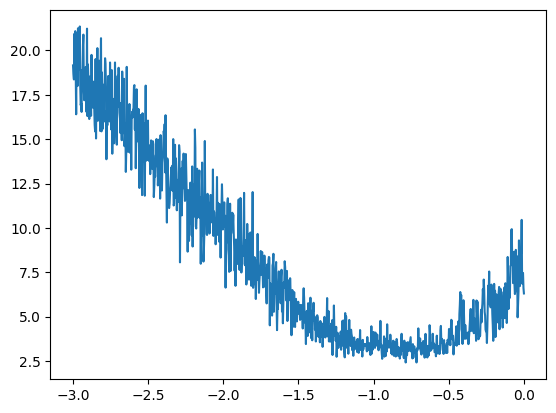

In [29]:
#finding optimal learning rate
plt.plot(lri, lossi)

From this we can conclude that 0.1 is a good lr rate